# Setting the snow depth threshold to separate drift from not-drift snow.

Matthew, I wanted to re-create your figure using the cumulative distribution function on a hypothetical simulated snow cover that is normally distributed where &mu; = 0.5 and &sigma; = 0.2.

Essentially we are interested in the empirical cumulative distribution function (CDF) of our hypothetical snowcover - just reversed.

After looking into a bit more I have learned that in engineering these reversed CDFs are known as "exceedance" curves: they tell you the probability that an observation will not exceed the x-value.

We can make a function that generates populations and plots these exceedance curves:

In [2]:
# Importing libraries (all stable)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.stats import lognorm
from scipy.interpolate import interp1d

In [3]:
def generate_norm_synthetic_snow(mu, sigma, N):
    """Generates a normally distributed snowcover.
       Negative depths are culled"""
    
    # Set the random seed for stability
    np.random.seed(42)
    s = np.random.normal(mu, sigma, N)
    s = s[s>=0]
    
    return s


def generate_lognorm_synthetic_snow(mu, sigma, N):
    """Generates a *log*-normally distributed snowcover.
       Negative depths are culled"""
    
    s = lognorm(sigma, mu, N)
    s = s[s>=0]
    
    return s


def plot_pdf(s, n_bins):
    """Computes and plots a normalized PDF"""
    
    sigma = np.std(s)
    mu = np.mean(s)
    
    fig = plt.figure(figsize=(8,5))
    count, bins, ignored = plt.hist(s, n_bins, density=True)
    ln = 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2))

    plt.plot(bins, ln, linewidth=2, color='r', label='PDF')
    plt.xlabel('Snow Depth [m]')
    plt.ylabel('Normalized Frequency')
    return ln, bins

def compute_pct_area(s):
    """
    This is logic currently in the paper.
    1. Sort the snowcover by depth
    2. For each depth, count how many samples are greater
    than or equal to that depth.
    3. The number of samples is the area.
    """
    
    s_sort = np.sort(s)
    area_pcts = []
    total_area = s.size

    for i in s_sort:
        drift_mask = (s >= i)
        drift_area = np.nansum(drift_mask)
        drift_area_pct = (drift_area / total_area)
        area_pcts.append(drift_area_pct)
    
    return np.array(area_pcts)

def compute_pct_volume(s):
    
    """
    This is logic currently in the paper.
    1. Sort the snowcover by depth
    2. For each depth, mask out the depths below that depth
    3. Add up all the snow depths remaining
    4. Multiply by 1 for the volume.
    """
    s_sort = np.sort(s)
    vol_pcts = []
    total_vol = s.sum()

    for i in s_sort:
        drift_mask = (s >= i)
        drift_vol = np.nansum(drift_mask * s * 1)
        drift_vol_pct = (drift_vol / total_vol)
        vol_pcts.append(drift_vol_pct)
    
    return np.array(vol_pcts)

def main(mu, sigma, N):
    s = generate_norm_synthetic_snow(mu, sigma, N)
    pct_area = compute_pct_area(s)
    pct_vol = compute_pct_volume(s)
    df = pd.DataFrame(index=pd.Index(np.sort(s)))
    df['percent area'] = pct_area * 100
    df['percent vol.'] = pct_vol * 100
    df['percent vol. - area diff.'] = df['percent vol.'] - df['percent area']
    return df, s

    

In [5]:
# 100 iterations of a random normal distribution (N - 10,000)

ixmins = []
    
df, s = main(0.50, 0.20, 10000)
dd = np.gradient(df['percent vol. - area diff.'], np.sort(s))
i = np.argmin(dd)
ixmins.append(df.iloc[i].name)

    
print(np.mean(ixmins))
print(np.std(ixmins))

0.7841008574542127
0.0


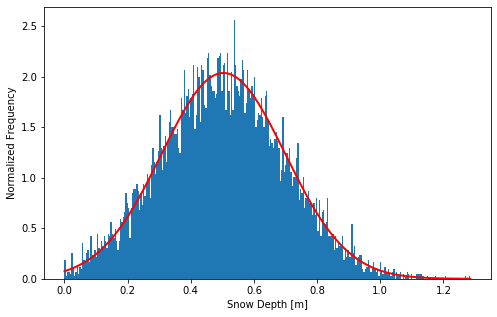

In [6]:
l, b = plot_pdf(s, 300)

In [ ]:
#plt.plot(l)
plt.plot(np.gradient(l))


In [ ]:
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib inline

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)

# Adjust the subplots region to leave some space for the sliders and buttons
fig.subplots_adjust(left=0.25, bottom=0.25)

# Initial parameters
mu_0 = 0.5
sig_0 = 0.2
N_0 = 1000

# Draw the initial plot
# The 'line' variable is used for modifying the line later

count, bins, ignored = ax.hist(generate_norm_synthetic_snow(mu_0,
                                                            sig_0,
                                                            N_0),
                               30, density=True)
ln = 1 / (sig_0 * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu_0)**2 / (2 * sig_0**2))
[line] = ax.plot(bins, ln, linewidth=2, color='r', label='PDF')

#plt.xlabel('Snow Depth [m]')
#plt.ylabel('Normalized Frequency')


# Add two sliders for tweaking the parameters

# Define an axes area and draw a slider in it
mu_slider_ax  = fig.add_axes([0.25, 0.15, 0.65, 0.03])
mu_slider = Slider(mu_slider_ax, 'mu', 0.30, 0.80, valinit=mu_0)

sig_slider_ax = fig.add_axes([0.25, 0.1, 0.65, 0.03])
sig_slider = Slider(sig_slider_ax, 'sigma', 0.1, 0.8, valinit=sig_0)

# Define an action for modifying the line when any slider's value changes
def sliders_on_changed(val):
    line.set_ydata(generate_norm_synthetic_snow(mu_slider.val, sig_slider.val, N_0))
    fig.canvas.draw_idle()
mu_slider.on_changed(sliders_on_changed)
sig_slider.on_changed(sliders_on_changed)

plt.show()

In [ ]:
vol_area_delta = pct_vol - pct_area
fig, ax1 = plt.subplots(figsize=(8,5))

ax1.set_xlabel('Snow Depth [m]')
ax1.set_ylabel('percent difference', color='m')
ax1.plot(np.sort(s), vol_area_delta*100, color='m', label='Drift Volume - Drift Area')
ax1.tick_params(axis='y', labelcolor='m')
plt.legend(loc=5)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('percent', color='k')  # we already handl%ed the x-label with ax1
ax2.plot(np.sort(s), pct_vol*100, color='blue', label='Drift Volume')
ax2.plot(np.sort(s), pct_area*100, color='green', label='Drift Volume')
ax2.tick_params(axis='y', labelcolor='k')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
plt.show()


In [ ]:
d_vol_area_delta = np.gradient(vol_area_delta*100)
plt.plot(np.sort(s), vol_area_delta*100)
ax = plt.gca()
y = ax.lines[0].get_ydata()


We can now see in the above figure that there is about a 70% chance that an observation from this snowcover will exceed 0.40 m in depth.

This may be useful if you a gambler, but to start defining drifts we also need to know 

In [ ]:
def plot_reversed_cdf(s, n_bins):
        
    fig = plt.figure(figsize=(8,5))

    rev_cdf = plt.hist(s, bins=n_bins, density=True,
                       histtype='step', cumulative=-1)

    plt.cla()
    plt.plot(np.sort(s), rev_cdf[0], color='m', lw=2)
    plt.xlabel('Snow Depth [m]')
    plt.ylabel('Probability of Exceedance')        
    plt.show()

    return rev_cdf[0]


In [ ]:
def compute_exceedance_prob(s):

# sort data
s_sorted = np.sort(s)

# Count total obervations
n = s.size
# Add a numbered column 1 -> n to use in return calculation for rank
longmont_discharge_sorted.insert(0, 'rank', range(1, 1 + n))
# Calculate probability - note you may need to adjust this value based upon the time period of your data
longmont_discharge_sorted["probability"] = (
    (n - longmont_discharge_sorted["rank"] + 1) / (n + 1))
longmont_discharge_sorted["return-years"] = (
    1 / longmont_discharge_sorted["probability"])
